In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

In [3]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

In [6]:
df = pd.read_csv("2110.csv",
                 index_col = "Date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_20212\3107924521.py:1: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("2110.csv",


,Open,High,Low,Close
Date,,,,
2004-10-18,482.58,482.58,473.51,478.04
2004-10-19,476.23,480.76,474.41,475.32
2004-10-20,477.14,478.95,468.06,468.06
2004-10-21,468.06,471.69,462.62,468.06
2004-10-24,472.60,476.23,457.18,467.16


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2004-10-18 to 2024-11-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3834 non-null   float64
 1   High    3834 non-null   float64
 2   Low     3834 non-null   float64
 3   Close   3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


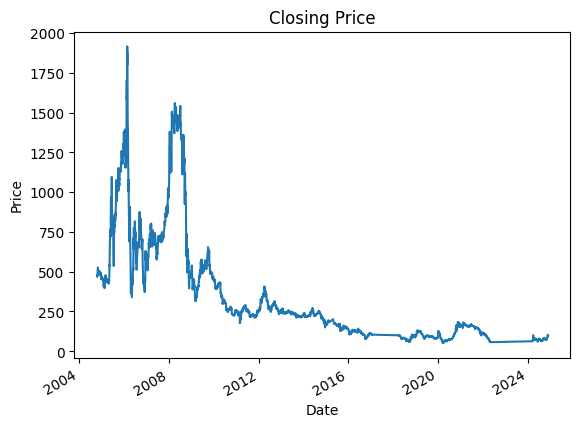

In [8]:
df['Close'].plot()
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_20212\2881670252.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df['Close'][df.index<'1/1/2015'].resample('M').mean(),


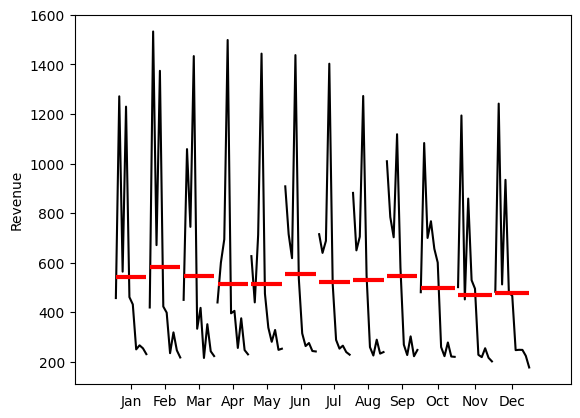

In [11]:
month_plot(df['Close'][df.index<'1/1/2015'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

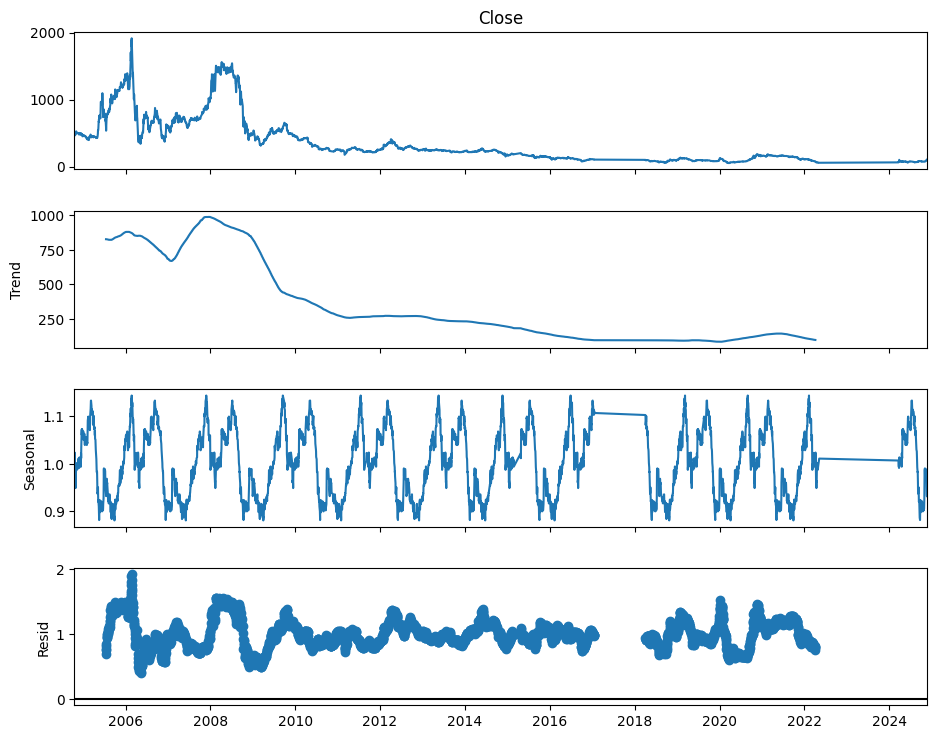

In [12]:
decomposition = seasonal_decompose(df['Close'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

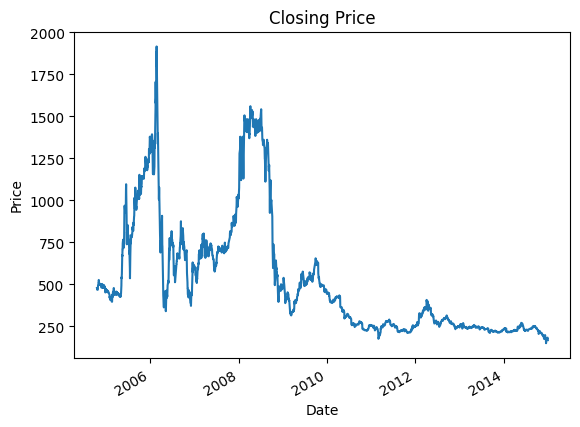

In [13]:
df=df[df.index<'1/1/2015']
df['Close'].plot()
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


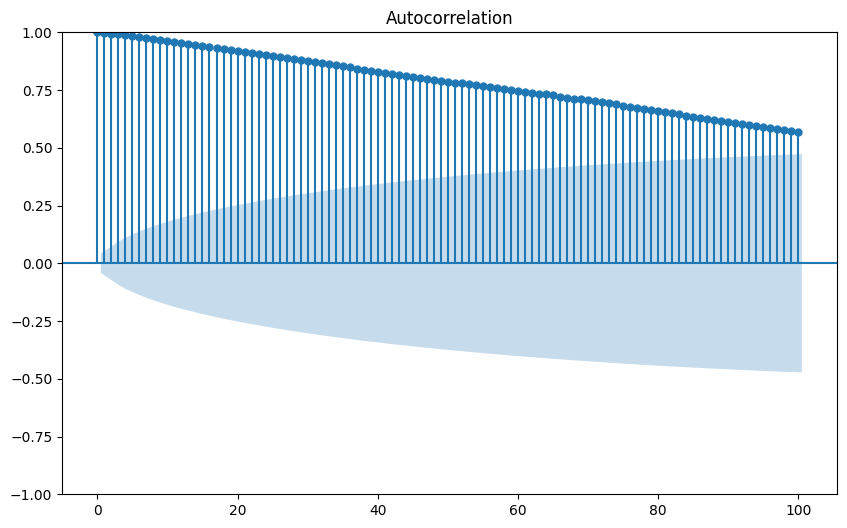

In [15]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['Close'], lags = 100, ax = ax)
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df.Close)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 0.193918
Evidence suggests that the time series is not stationary.


In [ ]:
df['y_diff'] = df.Close.diff()
df['y_diff']

C:\Users\pc\AppData\Local\Temp\ipykernel_20212\971594362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_diff'] = df.Close.diff()['2004-10-19' :]


Date
2004-10-18      NaN
2004-10-19    -2.72
2004-10-20    -7.26
2004-10-21     0.00
2004-10-24    -0.90
              ...  
2014-12-25     0.54
2014-12-28     5.99
2014-12-29     0.18
2014-12-30   -13.06
2014-12-31    -2.00
Name: y_diff, Length: 2186, dtype: float64

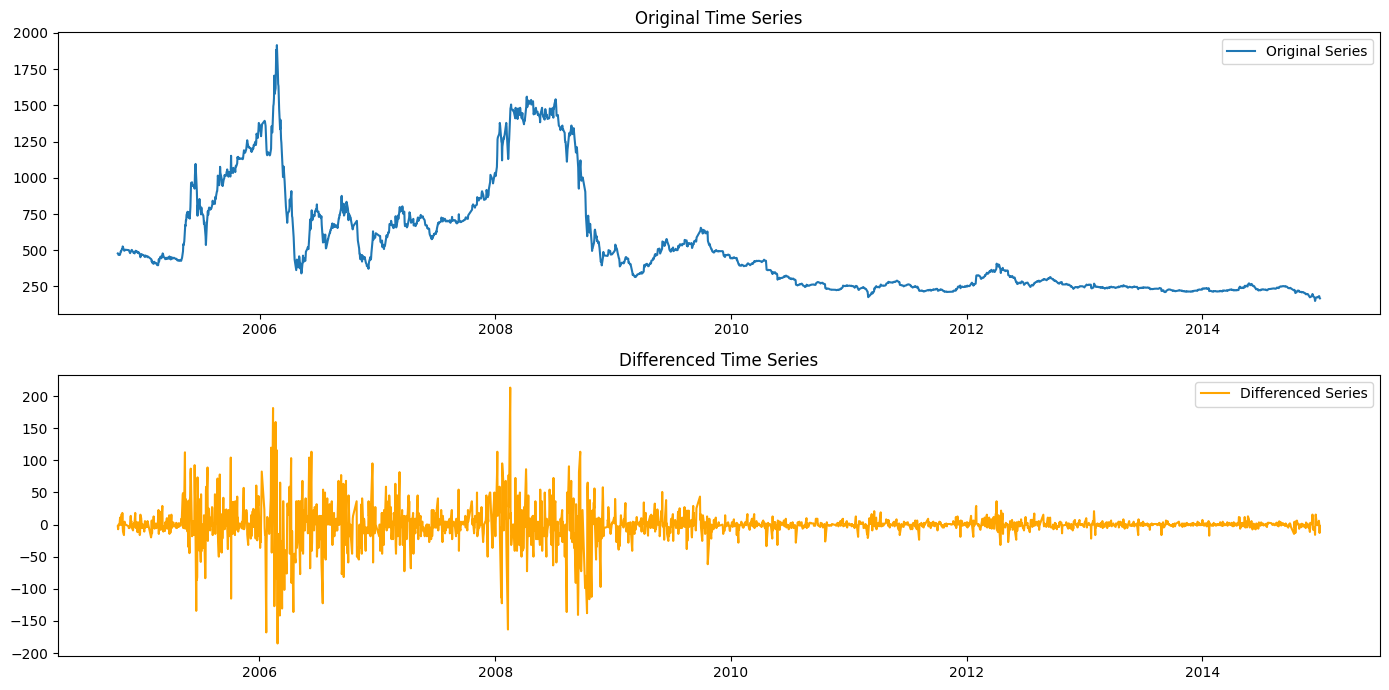

In [25]:
# Plotting the original and differenced series
# Set the size of the plot to 14 inches by 7 inches
plt.figure(figsize=(14, 7))

# Subplot for the original series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.Close, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['y_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

In [26]:
# Perform ADF test without null values
# 'result' contains the test statistic and the p-value.
result = adfuller(df['y_diff'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


    

p-value: 0.000000
Evidence suggests that the time series is stationary.


In [27]:
test_days = 100 # Number of days to reserve for testing
train, test = df.iloc[:-test_days], df.iloc[-test_days:]
test

,Open,High,Low,Close,y_diff
Date,,,,,
2014-08-06,234.94,236.75,234.03,234.94,-0.54
2014-08-07,234.94,235.85,234.94,235.12,0.18
2014-08-10,234.94,237.66,234.94,236.57,1.45
2014-08-11,236.75,237.66,235.85,236.75,0.18
2014-08-12,236.75,237.66,234.94,235.85,-0.90
...,...,...,...,...,...
2014-12-25,175.98,178.70,174.16,176.70,0.54
2014-12-28,178.70,185.05,176.89,182.69,5.99
2014-12-29,183.23,187.77,182.33,182.87,0.18


In [83]:
#ARIMA without seasonality or exogenous variables (no sarimax)
model = auto_arima(train['Close'],
                   seasonal = False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2086
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -9784.012
Date:                Fri, 23 May 2025   AIC                          19578.023
Time:                        16:50:04   BIC                          19606.236
Sample:                             0   HQIC                         19588.361
                               - 2086                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0238      0.049      0.482      0.630      -0.073       0.120
ar.L2          0.7306      0.039     18.744      0.000       0.654       0.807
ma.L1          0.0724      0.052      1.395      0.163      -0.029       0.174
ma.L2         -0.7485      0.043    -17.379      0.000      -0.833      -0.664
sigma2       697.3028      8.199     85.050      0.000     681.234     713.372
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             12880.87
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMAX(2, 1, 2) is the best here

In [84]:
predictions_arima = model.predict(n_periods = len(test))
predictions_arima.index=    test.index
predictions_arima


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2014-08-06    235.886593
2014-08-07    235.907315
2014-08-10    236.204852
2014-08-11    236.227064
2014-08-12    236.444962
                 ...    
2014-12-25    237.180106
2014-12-28    237.180106
2014-12-29    237.180106
2014-12-30    237.180107
2014-12-31    237.180107
Length: 100, dtype: float64

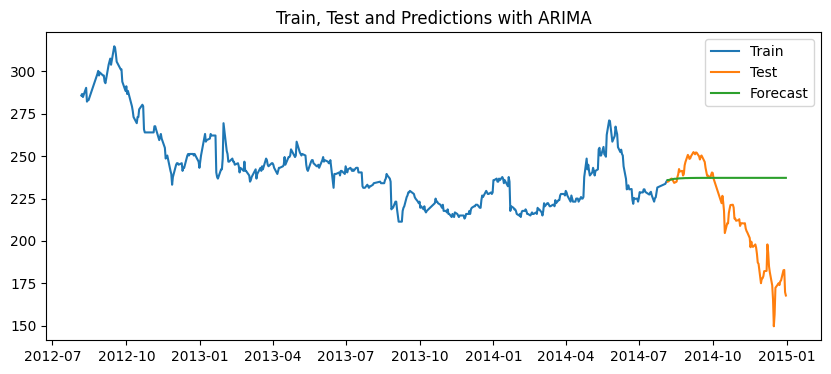

The MAE is 27.40
The RMSE is 35.64
The MAPE is 14.42 %


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [85]:
model_assessment(train['Close']['2012-08-06':], test['Close'], predictions_arima, "ARIMA")

In [86]:
#Sarima with seasonality and no exogenous variables (no sarimax)


model_sarima = auto_arima(train['Close'],
                          m = 7)
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2086
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -9784.012
Date:                Fri, 23 May 2025   AIC                          19578.023
Time:                        16:51:47   BIC                          19606.236
Sample:                             0   HQIC                         19588.361
                               - 2086                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0238      0.049      0.482      0.630      -0.073       0.120
ar.L2          0.7306      0.039     18.744      0.000       0.654       0.807
ma.L1          0.0724      0.052      1.395      0.163      -0.029       0.174
ma.L2         -0.7485      0.043    -17.379      0.000      -0.833      -0.664
sigma2       697.3028      8.199     85.050      0.000     681.234     713.372
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             12880.87
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
predictions_arima = model_sarima.predict(n_periods = len(test))
predictions_arima.index=    test.index
predictions_arima

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2014-08-06    235.886593
2014-08-07    235.907315
2014-08-10    236.204852
2014-08-11    236.227064
2014-08-12    236.444962
                 ...    
2014-12-25    237.180106
2014-12-28    237.180106
2014-12-29    237.180106
2014-12-30    237.180107
2014-12-31    237.180107
Length: 100, dtype: float64

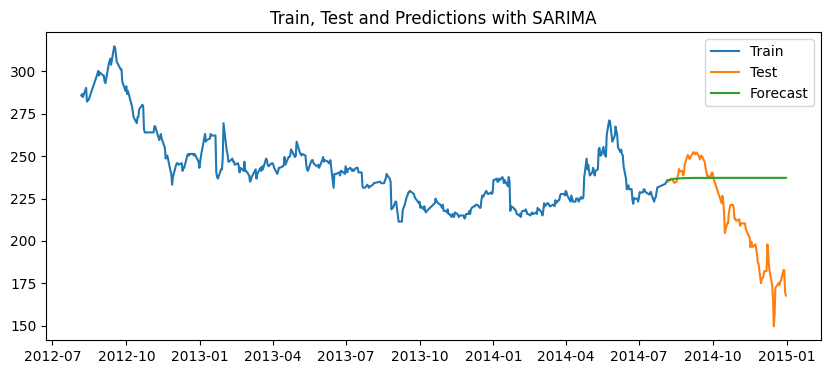

The MAE is 27.40
The RMSE is 35.64
The MAPE is 14.42 %


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [88]:
model_assessment(train['Close']['2012-08-06':], test['Close'], predictions_arima, "SARIMA")

In [47]:
test_days = 100 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]
exog_test.head()

,High,Low
Date,,
2014-08-06,236.75,234.03
2014-08-07,235.85,234.94
2014-08-10,237.66,234.94
2014-08-11,237.66,235.85
2014-08-12,237.66,234.94


In [ ]:
#sarimax with seasonality and exogenous variables (sarimax)


model_sarimax = auto_arima(train['Close'],
                           m = 5,
                           X = exog_train
                           )
model_sarimax.summary()

In [70]:
predictions_arima = model_sarimax.predict(n_periods = len(test) , X = exog_test)
predictions_arima.index=    test.index
predictions_arima

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2014-08-06    235.055210
2014-08-07    235.049005
2014-08-10    235.931418
2014-08-11    236.426306
2014-08-12    236.045255
                 ...    
2014-12-25    176.039336
2014-12-28    180.556683
2014-12-29    184.661259
2014-12-30    172.383349
2014-12-31    163.652345
Length: 100, dtype: float64

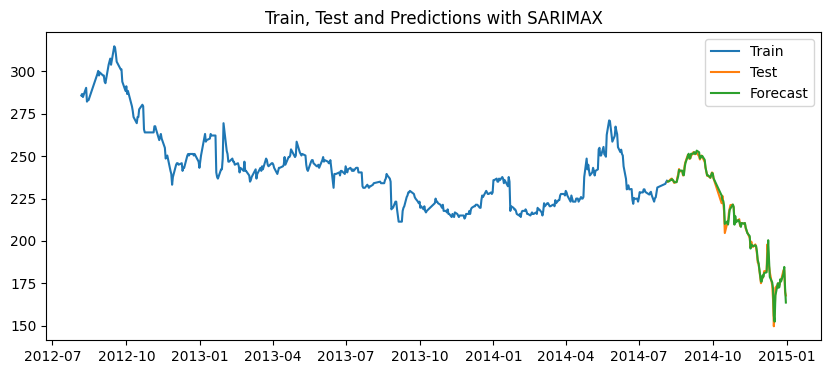

The MAE is 1.40
The RMSE is 2.12
The MAPE is 0.71 %


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [71]:
model_assessment(train['Close']['2012-08-06':], test['Close'], predictions_arima, "SARIMAX")

# Sarimax is just perfect 👌 for this dataset. It has a very low MAE and RMSE. The model predicts the stock prices with high accuracy."""
